In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
%matplotlib notebook
plt.style.use('classic')

#### Országnevek és országkódok beolvasása

In [2]:
country_codes = pd.read_csv('CountryCodes.csv')
country_codes.drop(columns=['Alpha-3 code', 'Numeric code', 'ISO 3166-2'], inplace=True)
country_codes.rename(columns={'English short name lower case' : 'name', 'Alpha-2 code' : 'code'}, inplace=True)

In [3]:
country_codes = country_codes.append({'name' : 'United States', 'code' : 'US'}, ignore_index=True)

C:\Users\LACI\AppData\Local\Temp\ipykernel_19384\3207834040.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  country_codes = country_codes.append({'name' : 'United States', 'code' : 'US'}, ignore_index=True)


In [4]:
country_codes.head()

,name,code
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


#### Nobel díjak feldolgozása
Az adatbázis nobel díjakat tartalmaz, a rekordok többek közt tartalmazzák a díjakat birtokló személyek nevét, születési országát, a díj tudomány területét és még egyéb adatokat.

- Mivel csak az országok nobeldíjasainak száma kell, így csupán a születési oszlopot kell használni.
  - A különböző országok kódjait összeszámolva megkapható az országok nobeldíjainak száma  

In [5]:
prizes = pd.read_csv('Nobel/nobel.csv', encoding='ISO-8859-1')
prizes = prizes.value_counts('bornCountryCode', dropna=True).rename_axis('code').to_frame('sumPrizes')

In [6]:
prizes.head()

,sumPrizes
code,
US,275
GB,101
DE,89
FR,56
RU,31


In [7]:
print(prizes.to_string())

      sumPrizes
code           
US          275
GB          101
DE           89
FR           56
RU           31
SE           30
PL           30
JP           29
IT           20
AT           19
NL           19
CA           18
CH           17
CN           13
NO           13
DK           12
AU           11
ZA            9
HU            9
BE            9
IN            8
ES            7
IL            6
CZ            6
EG            6
IE            5
RO            5
UA            5
PK            4
AR            4
BY            4
LT            3
PT            3
NZ            3
MX            3
FI            3
DZ            3
TR            3
CL            2
CO            2
GT            2
TL            2
MA            2
LU            2
LR            2
LC            2
KR            2
BA            2
IR            2
VE            1
AZ            1
YE            1
VN            1
BG            1
SK            1
SI            1
BR            1
BD            1
TT            1
TW            1
HR      

#### Lakossági adatok beolvasása


In [8]:
population = pd.read_csv('population.csv')

In [9]:
population.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1440297825,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1382345085,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,331341050,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,274021604,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,221612785,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [10]:
population.replace(country_codes['name'].to_list(), country_codes['code'].to_list(), inplace=True)
population.rename(columns={'Country (or dependency)' : 'code',
                           'Population (2020)' : 'population'}, inplace=True)
population = population[['code', 'population']]
population.shape

(235, 2)

In [11]:
population.drop(np.where(population['population']<1000000)[0], inplace=True)

In [12]:
population.head()

,code,population
0,CN,1440297825
1,IN,1382345085
2,US,331341050
3,ID,274021604
4,PK,221612785


In [13]:
population.set_index('code', inplace=True)
population.head()

,population
code,
CN,1440297825
IN,1382345085
US,331341050
ID,274021604
PK,221612785


#### Időjárási adatok beolvasásása

In [14]:
%%html
<a href="https://tcktcktck.org/countries">Éghajlati és időjárási adatok</a>

![title](climate.png)

In [15]:
with open("Climate.txt", "r") as f:
    climate = f.readlines()
climate = climate[0]
r = r"<\/i> (?P<Country>[\w \-\']*)<\/a><\/td><td>(?P<ClimateZone>\w*)<\/td><td>\-?\d+\.?\d*<\/td><td>(?P<AvgTemp>\-?\d+\.?\d*)"
pattern = re.compile(r)
climate = pd.DataFrame([match.groupdict() for match in pattern.finditer(climate)])
climate.replace(country_codes['name'].to_list(), country_codes['code'].to_list(), inplace=True)
climate.rename(columns={'Country' : 'code', 'ClimateZone' : 'climate', 'AvgTemp' : 'temp'}, inplace=True)
climate.set_index('code', inplace=True)
climate['temp'] = climate['temp'].astype('float64')

In [16]:
climate.head()

,climate,temp
code,,
AF,DSB,15.70
AL,CSB,15.17
DZ,BWH,20.00
AS,AW,28.00
AD,CFB,7.17


#### A dataset lesz az egyesített adattábla

In [17]:
dataset = pd.concat([population, prizes, climate], axis=1)

In [18]:
dataset['sumPrizes'].fillna(0, inplace=True)
dataset.dropna(inplace=True)

In [19]:
dataset['prizePerMillion'] = dataset['sumPrizes']/(dataset['population']/1000000)

In [20]:
dataset.sort_values(axis=0, by='prizePerMillion', ascending=False)

,population,sumPrizes,climate,temp,prizePerMillion
code,,,,,
SE,10110233.0,30.0,DFB,7.25,2.967291
NO,5428594.0,13.0,DFC,5.03,2.394727
AT,9015361.0,19.0,DFB,8.82,2.107514
DK,5795780.0,12.0,CFB,9.89,2.070472
CH,8665615.0,17.0,DFC,9.10,1.961777
...,...,...,...,...,...
SO,15965848.0,0.0,BWH,27.91,0.000000
TD,16502877.0,0.0,CFA,30.88,0.000000
KH,16758448.0,0.0,AM,28.97,0.000000


<IPython.core.display.Javascript object>


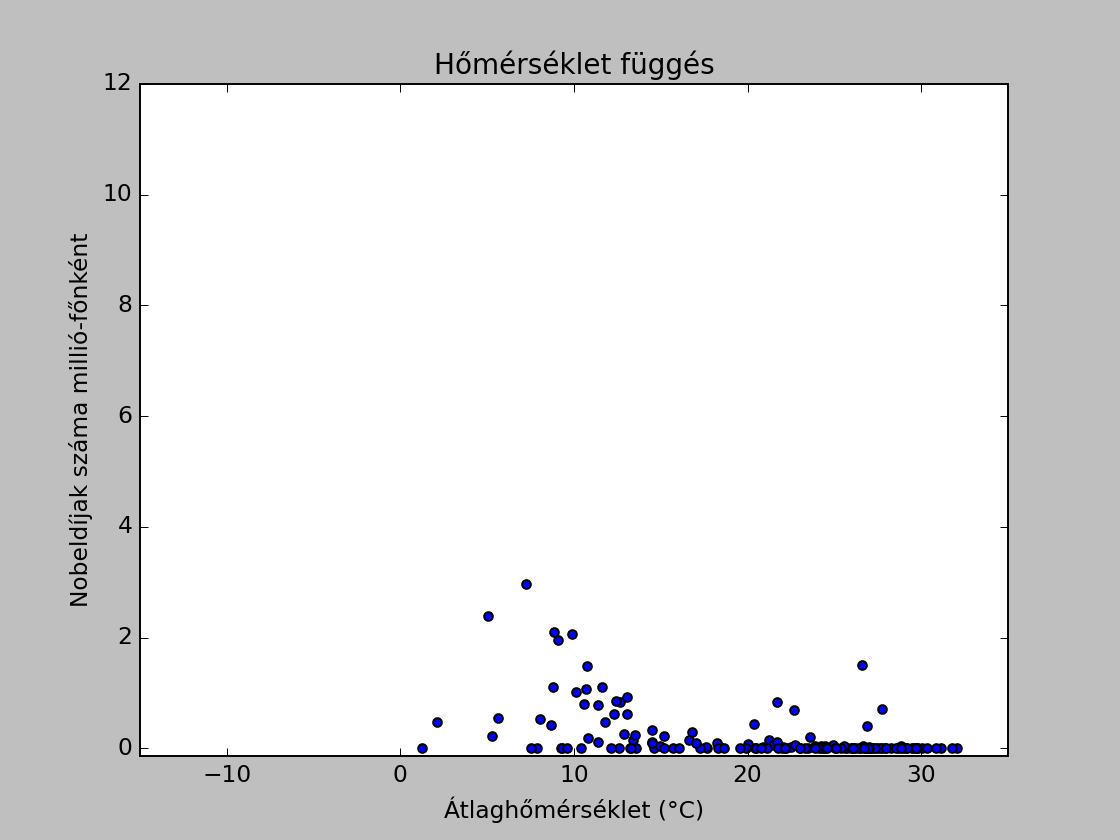

In [21]:
x = dataset['temp'].to_list()
y = dataset['prizePerMillion'].to_list()

fig, ax = plt.subplots()
ax.set_title("Hőmérséklet függés")
ax.set_xlabel("Átlaghőmérséklet (°C)")
ax.set_ylabel("Nobeldíjak száma millió-főnként")
ax.set_xlim(-15, 35)
ax.set_ylim(-0.14, 12)
ax.scatter(x, y)

#### APPMPC - Average prize per million per climaticzone.

In [22]:
APPMPC = pd.DataFrame(dataset.groupby('climate')['prizePerMillion'].mean())
APPMPC.sort_values('prizePerMillion', inplace=True)

In [23]:
APPMPC

,prizePerMillion
climate,
DWB,0.000000
DSB,0.000000
DSC,0.000000
CWA,0.002051
AF,0.004238
CWB,0.015587
BSK,0.021788
BWH,0.028982
CSB,0.046658


<IPython.core.display.Javascript object>


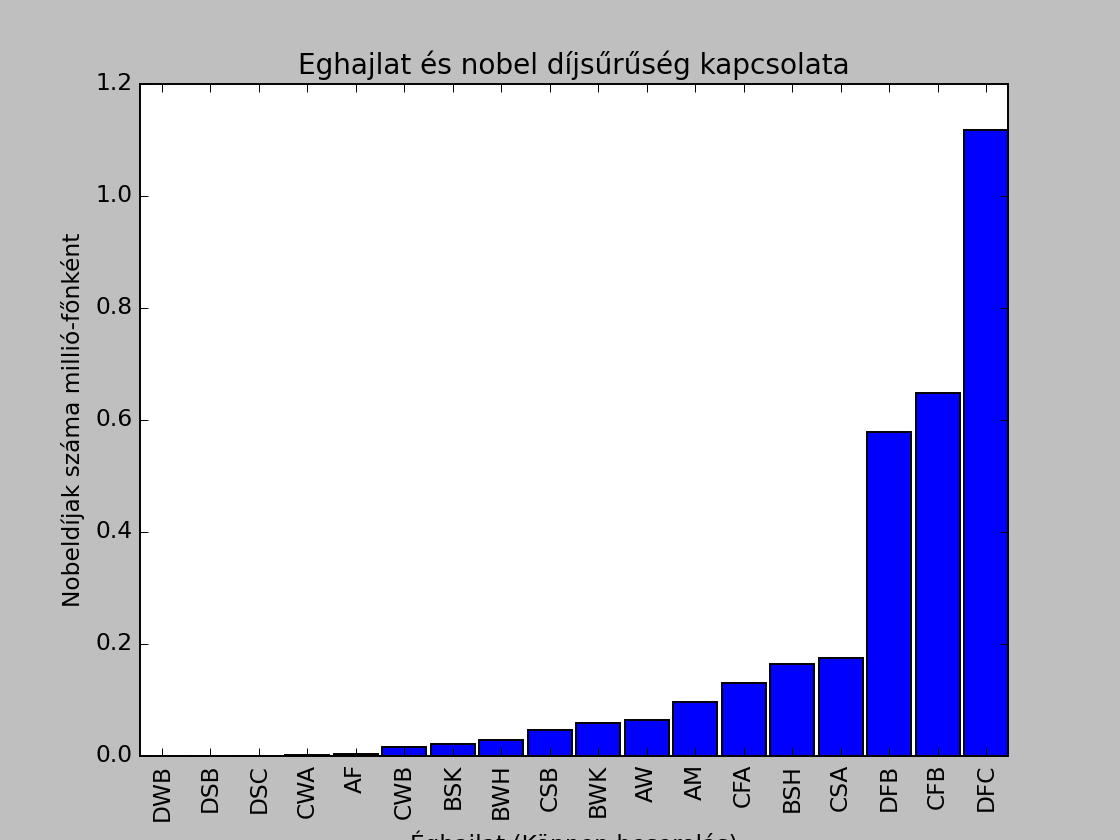

<BarContainer object of 18 artists>

In [24]:
height = APPMPC['prizePerMillion']
bars = APPMPC.index
ticks = np.arange(len(bars))

fig, ax = plt.subplots()
ax.set_title("Eghajlat és nobel díjsűrűség kapcsolata")
ax.set_xlabel("Éghajlat (Köppen besorolás)")
ax.set_ylabel("Nobeldíjak száma millió-főnként")
ax.set_xticks(ticks)
ax.set_xticklabels(bars, rotation=90)
ax.bar(bars, height, width=0.9)

In [25]:
import geopandas as gpd

In [26]:
world_map = gpd.read_file(r'CountryBounds\countries.shp')
world_map.rename(columns={"NAME" : "name", "ISO2" : "code"}, inplace=True)
world_map = world_map[['name', 'code', 'geometry']]
world_map.shape

(265, 3)

In [27]:
# world_map = world_map.merge(climate, on='code', how='left')
world_map = world_map.merge(dataset, on='code', how='left')

<IPython.core.display.Javascript object>


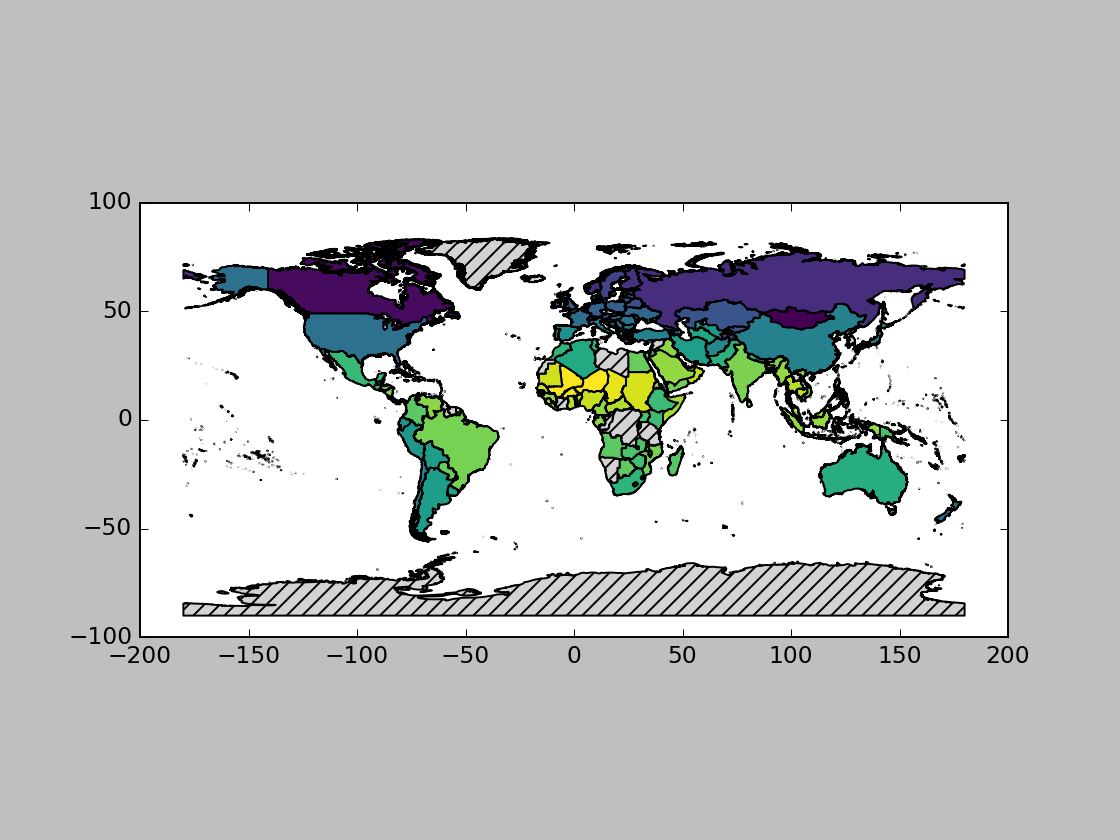

<AxesSubplot:>

In [28]:
world_map.plot(column='temp', cmap='viridis', missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Missing values",
            })

In [29]:
plt.close()

<IPython.core.display.Javascript object>


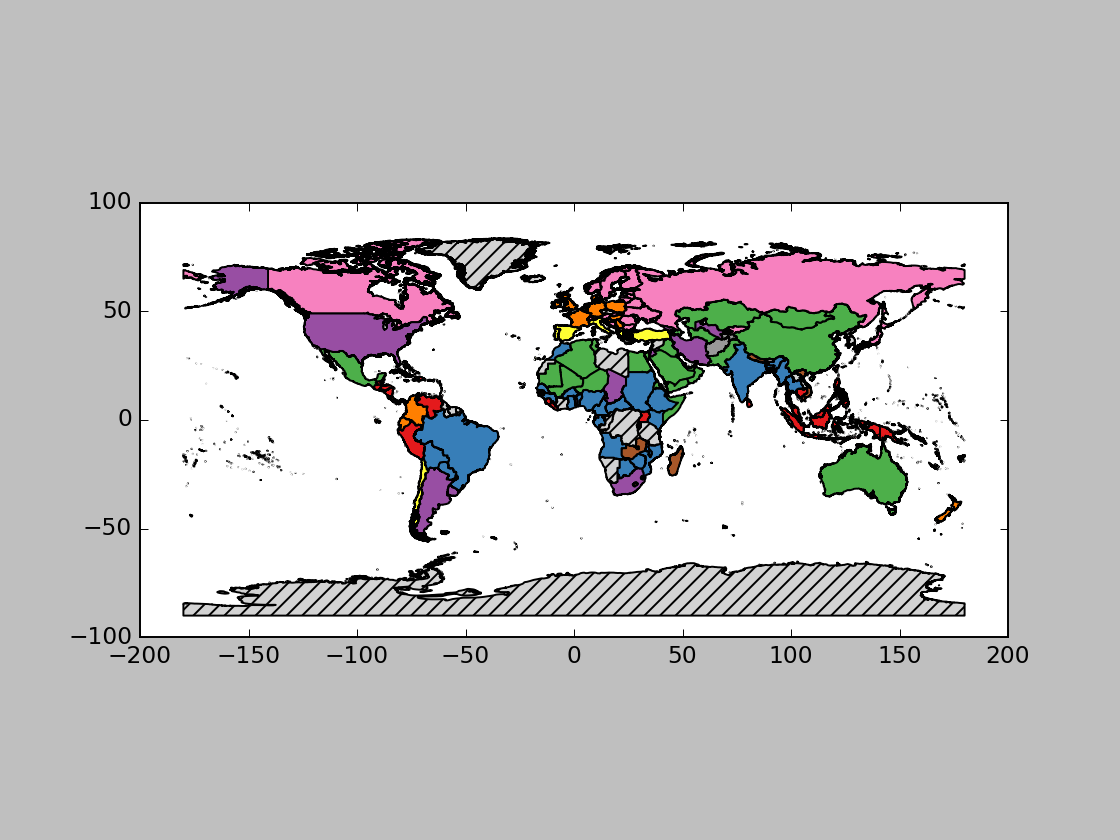

<AxesSubplot:>

In [30]:
world_map.plot(column='climate', cmap='Set1', categorical=True, missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Missing values",
            })

<IPython.core.display.Javascript object>


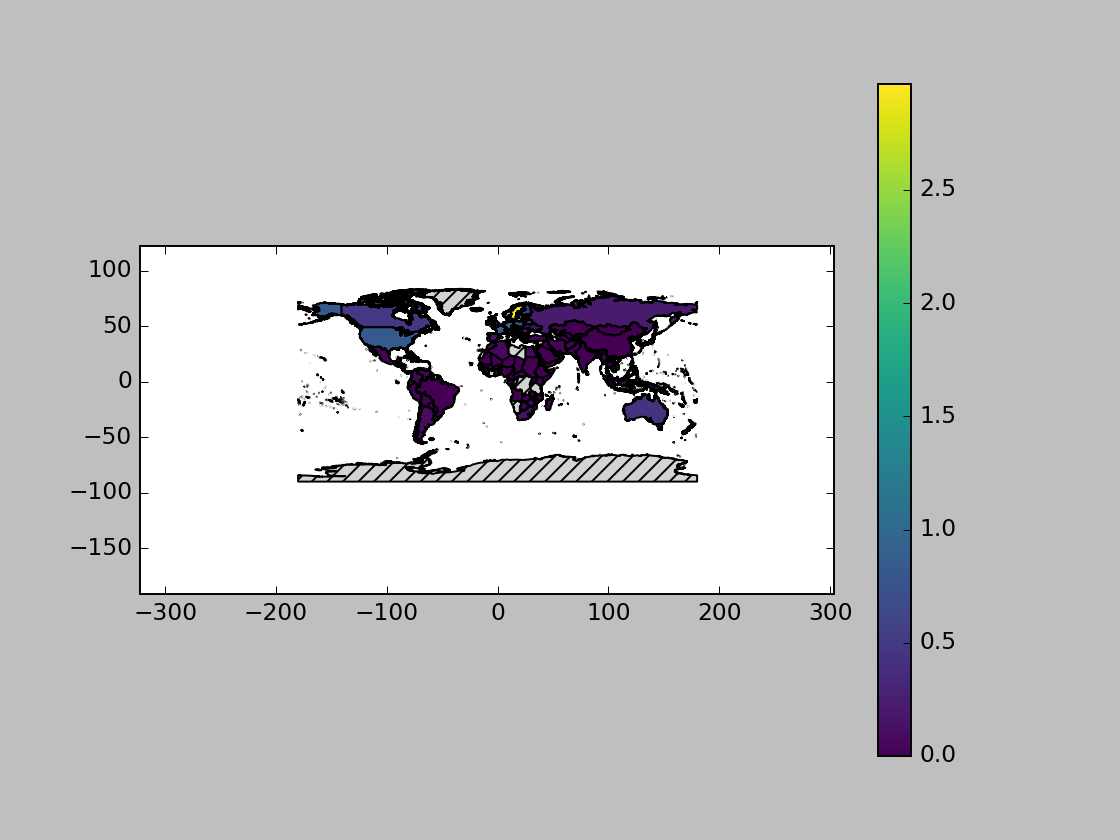

<AxesSubplot:>

In [31]:
world_map.plot(column='prizePerMillion', cmap='viridis', legend=True, missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Missing values",
            })

In [32]:
world_map['climatePrizePerMillion'] = world_map['climate'].replace(APPMPC.index, APPMPC['prizePerMillion'])
world_map

,name,code,geometry,population,sumPrizes,climate,temp,prizePerMillion,climatePrizePerMillion
0,Åland,AX,"MULTIPOLYGON (((20.99567 60.64228, 20.99261 60...",NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AF,"POLYGON ((73.27336 36.88856, 73.26195 36.89025...",39074280.0,0.0,DSB,15.70,0.000000,0.000000
2,Albania,AL,"MULTIPOLYGON (((20.98057 40.85522, 20.98096 40...",2877239.0,0.0,CSB,15.17,0.000000,0.046658
3,Algeria,DZ,"MULTIPOLYGON (((-8.67387 27.29807, -8.67172 27...",43984569.0,3.0,BWH,20.00,0.068206,0.028982
4,American Samoa,AS,"MULTIPOLYGON (((-171.07492 -11.06860, -171.078...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
260,Western Sahara,EH,"MULTIPOLYGON (((-17.05185 20.77416, -17.05445 ...",NaN,NaN,NaN,NaN,NaN,NaN
261,Yemen,YE,"MULTIPOLYGON (((53.10706 16.65440, 53.09564 16...",29935468.0,1.0,BWH,25.53,0.033405,0.028982
262,Zambia,ZM,"POLYGON ((30.41826 -15.61757, 30.41293 -15.622...",18468257.0,0.0,CWA,23.33,0.000000,0.002051
263,Zimbabwe,ZW,"POLYGON ((28.84701 -21.74224, 28.83875 -21.738...",14899771.0,1.0,BSH,22.73,0.067115,0.163976


<IPython.core.display.Javascript object>


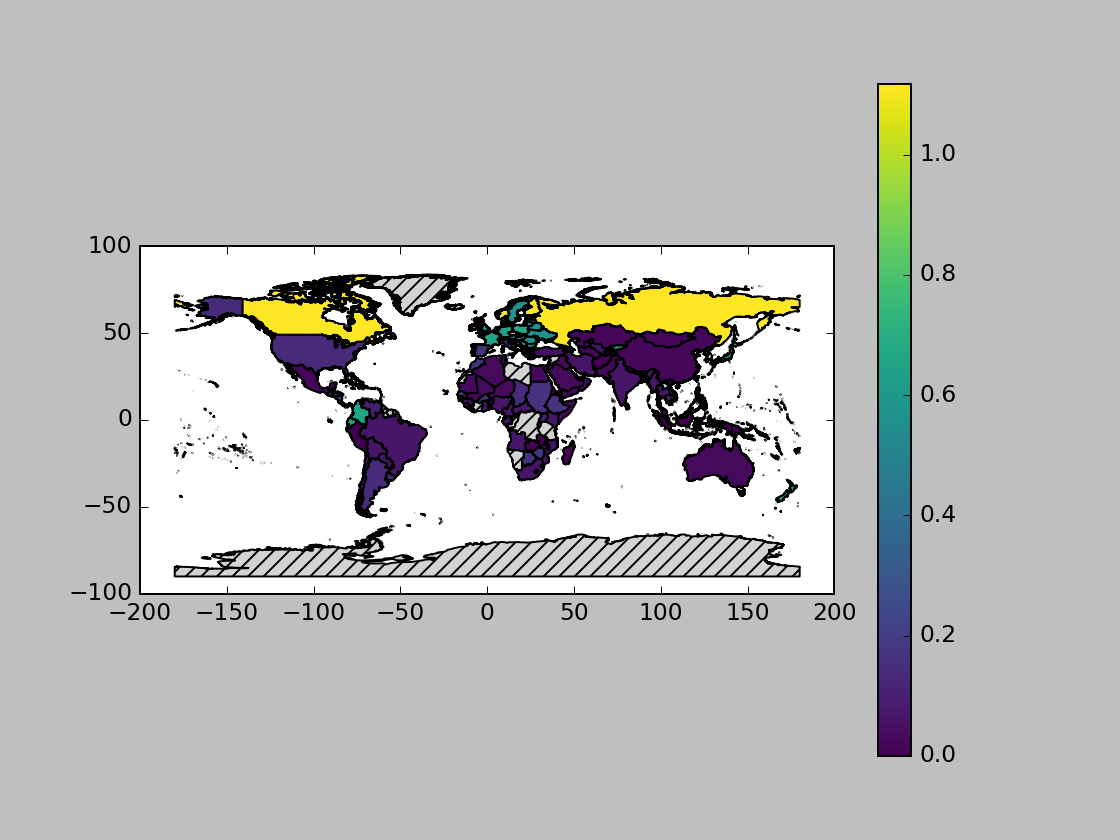

<AxesSubplot:>

In [33]:
world_map.plot(column='climatePrizePerMillion', cmap='viridis', legend=True, missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Missing values",
            })